### imports

In [5]:
# imports

import io
import glob
import os
import sys
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft
import pandas as pd
import seaborn as sns
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# prompt: Access a folder on google drive and import the data locally
from google.colab import drive
drive.mount('/content/drive/')
# helper files
sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from UAV_project_preprocessing_and_visualization_helper_functions import *

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


### Loading results

In [7]:
all_results_df = pd.DataFrame()
for file in glob.glob('./Features Extraction Results/features_extraction_results*'):
  print(file)
  with open(file, 'rb') as f:
    all_results_df = all_results_df.append(pickle.load(f))

all_results_df.reset_index(drop=True, inplace=True)

./Features Extraction Results/features_extraction_results_01_20_2024, 21:26:14
./Features Extraction Results/features_extraction_results_01_21_2024, 05:43:12
./Features Extraction Results/features_extraction_results_01_21_2024, 06:18:31
./Features Extraction Results/features_extraction_results_01_22_2024, 06:47:07
./Features Extraction Results/features_extraction_results_01_22_2024, 07:28:08
./Features Extraction Results/features_extraction_results_01_22_2024, 07:41:17
./Features Extraction Results/features_extraction_results_01_22_2024, 09:20:06
./Features Extraction Results/features_extraction_results_01_22_2024, 13:18:35
./Features Extraction Results/features_extraction_results_01_22_2024, 13:24:23


In [8]:
all_results_df = all_results_df[all_results_df['Model'] == 'DT']
all_results_df.reset_index(drop=True, inplace=True)

In [9]:
len(all_results_df)

120

In [10]:
all_results_df.head(3)

,datetime,Sample Duration,Test Files,Split Config,Features Config,Model,Model Config,Evaluation Report,UAV precision,UAV recall,UAV f1,Total f1
0,"01/22/2024, 13:18:35",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",DT,"{'max_depth': 5, 'model_random_state': 24}","{'airplane': {'precision': 0.751219512195122, ...",0.645407,0.780209,0.698254,0.852328
1,"01/22/2024, 13:18:35",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",DT,"{'max_depth': 7, 'model_random_state': 24}","{'airplane': {'precision': 0.8461538461538461,...",0.677474,0.756811,0.708736,0.862927
2,"01/22/2024, 13:18:35",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",DT,"{'max_depth': 10, 'model_random_state': 24}","{'airplane': {'precision': 0.8628571428571429,...",0.711382,0.775032,0.735086,0.870872


In [11]:
def extract_from_column(df, col, field):
  return df[col].apply(lambda x: x[field])

def features_type(df):
  # extremum = extract_from_column(df, 'Features Config', 'extremum')
  # curve = extract_from_column(df, 'Features Config', 'curve')
  # f = zip(extremum, curve)
  d_map = {
    (True, True): 'all',
    (True, False): 'range dependent',
    (False, True): 'range independent',
    (False, False): 'none'
  }
  return df['Features Config'].apply(lambda x: d_map[(x['extremum'], x['curve'])])

In [12]:
all_results_df['Max Depth'] = extract_from_column(all_results_df, 'Model Config', 'max_depth')
all_results_df['Max Depth'].fillna(value=100, inplace=True)
all_results_df['Model Random State'] = extract_from_column(all_results_df, 'Model Config', 'model_random_state')
all_results_df['Split Random State'] = extract_from_column(all_results_df, 'Split Config', 'random_state')
all_results_df['Features Type'] = features_type(all_results_df)

In [13]:
all_results_df.head(3)

,datetime,Sample Duration,Test Files,Split Config,Features Config,Model,Model Config,Evaluation Report,UAV precision,UAV recall,UAV f1,Total f1,Max Depth,Model Random State,Split Random State,Features Type
0,"01/22/2024, 13:18:35",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",DT,"{'max_depth': 5, 'model_random_state': 24}","{'airplane': {'precision': 0.751219512195122, ...",0.645407,0.780209,0.698254,0.852328,5.0,24,42,all
1,"01/22/2024, 13:18:35",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",DT,"{'max_depth': 7, 'model_random_state': 24}","{'airplane': {'precision': 0.8461538461538461,...",0.677474,0.756811,0.708736,0.862927,7.0,24,42,all
2,"01/22/2024, 13:18:35",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",DT,"{'max_depth': 10, 'model_random_state': 24}","{'airplane': {'precision': 0.8628571428571429,...",0.711382,0.775032,0.735086,0.870872,10.0,24,42,all


In [14]:
all_results_df[all_results_df['UAV f1'] == all_results_df['UAV f1'].max()]

,datetime,Sample Duration,Test Files,Split Config,Features Config,Model,Model Config,Evaluation Report,UAV precision,UAV recall,UAV f1,Total f1,Max Depth,Model Random State,Split Random State,Features Type
50,"01/22/2024, 13:18:35",15,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 15, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",DT,"{'max_depth': 10, 'model_random_state': 42}","{'airplane': {'precision': 0.8444444444444444,...",0.821997,0.869794,0.839417,0.911498,10.0,42,42,all


In [28]:
all_results_df['Evaluation Report'].iloc[50]

{'airplane': {'precision': 0.8444444444444444,
  'recall': 0.9047619047619048,
  'f1-score': 0.8735632183908046,
  'support': 42},
 'uav': {'precision': 0.559322033898305,
  'recall': 0.825,
  'f1-score': 0.6666666666666665,
  'support': 40},
 'bird': {'precision': 0.6666666666666666,
  'recall': 0.6666666666666666,
  'f1-score': 0.6666666666666666,
  'support': 9},
 'static-object': {'precision': 1.0,
  'recall': 0.920863309352518,
  'f1-score': 0.9588014981273408,
  'support': 278},
 'accuracy': 0.9024390243902439,
 'macro avg': {'precision': 0.767608286252354,
  'recall': 0.8293229701952723,
  'f1-score': 0.7914245124628697,
  'support': 369},
 'weighted avg': {'precision': 0.9263944390856338,
  'recall': 0.9024390243902439,
  'f1-score': 0.9103066079091633,
  'support': 369}}

### Slicing

In [16]:
slice_config = {
    'Model' : 'DT',
    'Split Random State' : 42,
    'Features Type' : 'all'
}

In [17]:
# prompt: slice a dataframe according to a given column value dictionary

# slice_df = all_results_df[all_results_df['Model'] == slice_config['Model']]
slice_df = all_results_df[all_results_df['Features Type'] == slice_config['Features Type']]
# slice_df = slice_df[slice_df['Split Random State'] == slice_config['Split Random State']]


In [18]:
# slice_df['UAV recall'].max()

In [19]:
# slice_df[slice_df['UAV recall'] == slice_df['UAV recall'].max()]

In [20]:
# slice_df[slice_df['UAV precision'] == slice_df['UAV precision'].max()]

In [21]:
# slice_df[slice_df['UAV f1'] == slice_df['UAV f1'].max()]

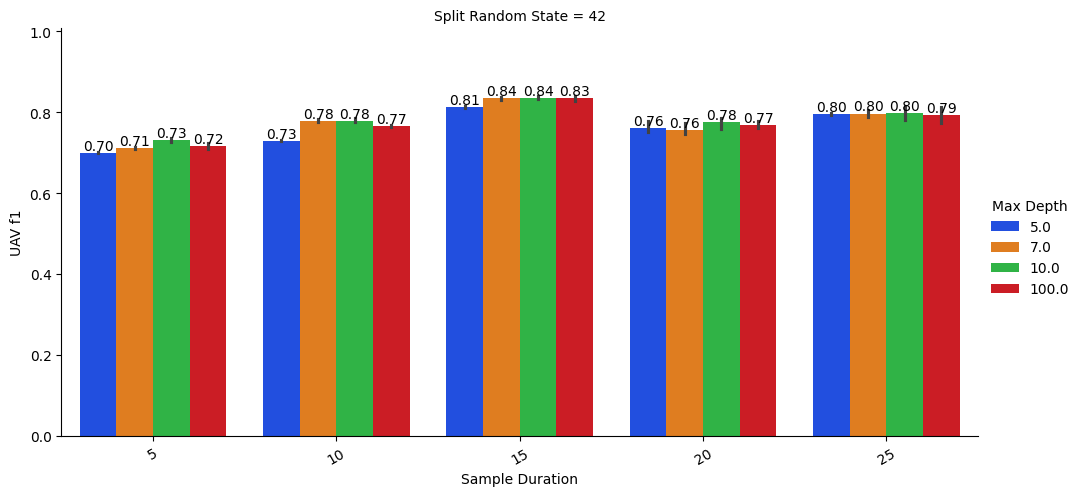

In [27]:
g = sns.catplot(data=slice_df, x = "Sample Duration", y = "UAV f1", hue = "Max Depth", col="Split Random State", kind="bar", aspect = 2, palette ="bright")

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = ['%0.2f' % v for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='edge')
    # plt.xticks(rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.margins(y=0.2)

In [23]:
# g = sns.catplot(data=slice_df, x = "Max Depth", y = "UAV recall", hue = "Sample Duration", col="Split Random State", kind="bar", aspect = 2)

# for ax in g.axes.ravel():
#     for c in ax.containers:
#         labels = ['%0.2f' % v for v in c.datavalues]
#         ax.bar_label(c, labels=labels, label_type='edge')
#     # plt.xticks(rotation=45)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
#     ax.margins(y=0.2)

### Compare features

In [24]:
feat_slice_df = all_results_df[all_results_df['Model'] == slice_config['Model']]
feat_slice_df = feat_slice_df[feat_slice_df['Max Depth'] == 5]
feat_slice_df = feat_slice_df[feat_slice_df['Split Random State'] == slice_config['Split Random State']]

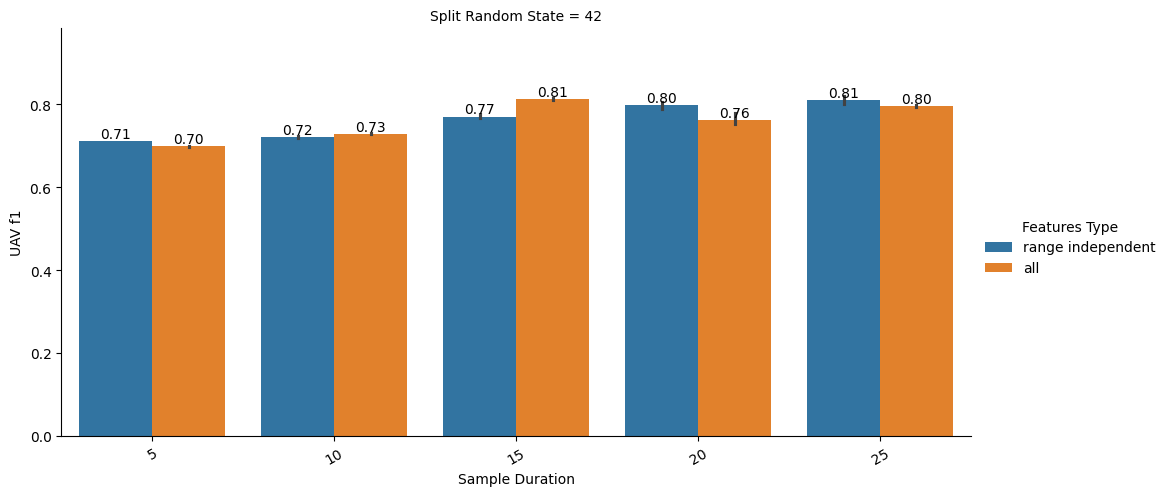

In [25]:
hue_order = ['range independent', 'all']

g = sns.catplot(data=feat_slice_df, x = "Sample Duration", y = "UAV f1", hue = "Features Type", col="Split Random State", kind="bar",hue_order=hue_order, aspect = 2)

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = ['%0.2f' % v for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='edge')
    # plt.xticks(rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.margins(y=0.2)

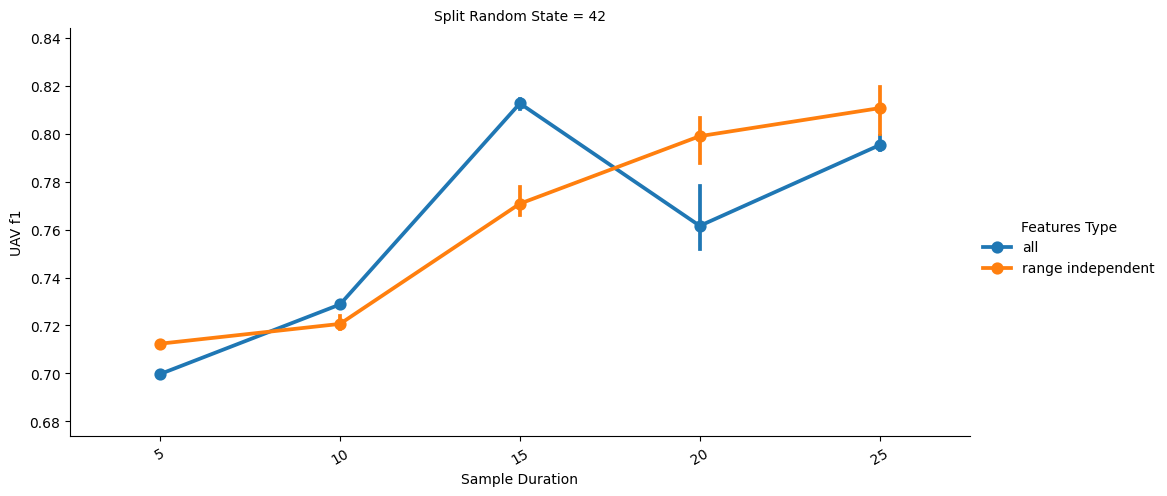

In [26]:
# hue_order = ['range dependent','range independent', 'all']

# g = sns.catplot(data=feat_slice_df, x = "Sample Duration", y = "UAV f1", hue = "Features Type", col="Split Random State", kind="bar",hue_order=hue_order, aspect = 2)
g = sns.catplot(data=feat_slice_df, x = "Sample Duration", y = "UAV f1", hue = "Features Type", col="Split Random State", kind="point", aspect = 2)

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = ['%0.2f' % v for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='edge')
    # plt.xticks(rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.margins(y=0.2)